In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [80]:
# Charger les données depuis le fichier CSV
file_path = "transition_energetique_pays_2023.xlsx"  # Chemin vers votre fichier
df = pd.read_excel(file_path)

In [81]:
# Sélection des colonnes pertinentes
features = [
    'Taux d\'énergie renouvelable', 
    'PIB par habitant (USD)', 
    'Taux de scolarisation secondaire (%)',
    'Accès à l\'électricité (%)'
]
target = 'Classification Transition Énergétique'

In [82]:
# Préparation des données
X = df[features]
y = df[target]

In [83]:
# Encodage des classes cibles
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convertit 'Avancée', 'Intermédiaire', 'Débutante' en 0, 1, 2 respectivement

# Standardisation des données pour les mettre sur une même échelle (centrage et réduction)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
# Division des données en ensemble d'entraînement et de test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [85]:
# Créer un DataFrame avec les caractéristiques et la classe cible
df_train = pd.DataFrame(X_train, columns=features)
df_train['class'] = le.inverse_transform(y_train)

In [86]:
# Filtrer uniquement les colonnes numériques
numerical_columns = df_train.select_dtypes(include=[np.number]).columns

In [87]:
# Calcul des moyennes des indicateurs pour chaque classe (Avancée, Intermédiaire, Débutante)
class_feature_means = pd.DataFrame(columns=le.classes_)
for c, rows in df_train.groupby('class'):
    # Sélectionner uniquement les colonnes numériques pour le calcul de la moyenne
    class_feature_means[c] = rows[numerical_columns].mean()
    
print(class_feature_means)

                                       Avancée  Débutante  Intermédiaire
Taux d'énergie renouvelable           1.554885  -0.740046       0.171936
PIB par habitant (USD)               -0.459706   0.126937       0.004142
Taux de scolarisation secondaire (%) -0.970429   0.458720       0.035041
Accès à l'électricité (%)            -1.194072   0.513150       0.111352


# 📊 Moyennes des Indicateurs par Classe 

## 🔹 Interprétation des Résultats  

### 1. **Taux d’énergie renouvelable**  
- **Les pays avancés** ont un taux d’énergie renouvelable **significativement plus élevé (1.55)** que les pays intermédiaires (0.17) et débutants (-0.74).  
- **Indicateur clé de discrimination** : il est fort pour les pays avancés mais faible, voire négatif, pour les pays débutants.  

---

### 2. **PIB par habitant (USD)**  
- Contrairement aux attentes, le **PIB est négatif (-0.45)** pour les pays avancés.  
- **Les pays intermédiaires** affichent un **PIB plus élevé (0.80)**, suivi par les pays débutants (0.12).  
- Cette observation pourrait refléter que certains pays avancés en transition énergétique sont à revenu modéré mais ont des politiques énergétiques ambitieuses.  

---

### 3. **Taux de scolarisation secondaire (%)**  
- **Les pays débutants** montrent une **scolarisation plus élevée (0.45)** que les pays avancés (-0.97).  
- Cela suggère que les pays avancés ont déjà dépassé cette phase de croissance éducative tandis que les pays débutants sont encore en pleine expansion dans ce domaine.  

---

### 4. **Accès à l’électricité (%)**  
- **Les pays débutants** affichent une valeur positive (0.51), tandis que les pays avancés ont un accès à l’électricité négatif (-1.19).  
- Cette observation pourrait traduire que les pays avancés se concentrent davantage sur des **améliorations qualitatives (énergies renouvelables)** plutôt que sur l'extension du réseau électrique.  

---

## 🏆 Points Clés :  
- **Taux d’énergie renouvelable** est **l’indicateur principal** pour distinguer les pays avancés.  
- **L’accès à l’électricité et la scolarisation secondaire** sont des facteurs discriminants pour les **pays débutants**.  
- **Le PIB par habitant** reste un indicateur complexe, mais il distingue particulièrement les pays intermédiaires.  

**Conclusion :**  
Les **indicateurs sociaux et économiques** jouent un rôle important dans la différenciation des pays selon leur niveau d’avancement dans la transition énergétique.  

In [88]:
# Calcul de la matrice de dispersion intra-classe (within-class scatter matrix)
within_class_scatter_matrix = np.zeros((X_train.shape[1], X_train.shape[1]))
for c, rows in df_train.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((X_train.shape[1], X_train.shape[1]))
    # Calculer la matrice de dispersion intra-classe
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(X_train.shape[1],1), class_feature_means[c].values.reshape(X_train.shape[1],1)
        s += (x - mc).dot((x - mc).T)
    
    within_class_scatter_matrix += s

In [89]:
# Calcul de la matrice de dispersion inter-classe (between-class scatter matrix)
feature_means = df_train.drop('class', axis=1).mean()
between_class_scatter_matrix = np.zeros((X_train.shape[1], X_train.shape[1]))
for c in class_feature_means:
    n = len(df_train.loc[df_train['class'] == c].index)  # Nombre de pays dans chaque classe
    
    mc, m = class_feature_means[c].values.reshape(X_train.shape[1],1), feature_means.values.reshape(X_train.shape[1],1)
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [90]:
# Calcul des valeurs propres et vecteurs propres (AFD) pour discriminer les classes
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [91]:
# Affichage des matrices de dispersion
print("Matrice de dispersion intra-classe :")
print(within_class_scatter_matrix)

print("\nMatrice de dispersion inter-classe :")
print(between_class_scatter_matrix)


Matrice de dispersion intra-classe :
[[ 20.8740064   -7.55892156  -6.29162704 -14.77177138]
 [ -7.55892156 169.99048487  51.30004139  40.15187901]
 [ -6.29162704  51.30004139 128.86777316  66.81470339]
 [-14.77177138  40.15187901  66.81470339  93.52958538]]

Matrice de dispersion inter-classe :
[[ 189.40911792  -47.72869186 -117.05204155 -139.1755065 ]
 [ -47.72869186   12.48312752   30.09195112   36.21405303]
 [-117.05204155   30.09195112   73.11608678   87.50357891]
 [-139.1755065    36.21405303   87.50357891  105.13180629]]


# 🧮 Matrices de Dispersion : Interprétation  

## 1. Matrice de Dispersion Intra-classe (Within-Class Scatter Matrix)  


### 🔹 Analyse :  
- Les valeurs élevées **sur la diagonale** (ex : `169.90`, `128.86`, `93.52`) indiquent une dispersion relativement importante au sein des classes.  
- Les éléments hors-diagonale (ex : `-7.55`, `40.15`) montrent des corrélations entre les différentes variables pour une même classe.  
- La **plus grande variabilité** est observée pour la deuxième variable (probablement **PIB par habitant**). Cela suggère que cette variable fluctue davantage au sein des classes.  

---

## 2. Matrice de Dispersion Inter-classe (Between-Class Scatter Matrix)  

### 🔹 Analyse :  
- Les valeurs sur la diagonale sont nettement **plus élevées** que dans la matrice intra-classe, en particulier pour la première variable (`189.41`).  
- Cela indique que **les moyennes des classes diffèrent fortement**, ce qui souligne une bonne séparation entre les classes.  
- Les éléments hors-diagonale négatifs (ex : `-117.05`, `-139.17`) montrent une forte corrélation négative entre certaines variables pour les différentes classes, ce qui pourrait refléter des compromis entre différents indicateurs (par exemple, des pays à faible PIB ayant de faibles taux de scolarisation).  

---

## 🏆 Interprétation Générale :  
- **Bonne discrimination** : La matrice de dispersion inter-classe est globalement **plus grande** que la matrice intra-classe, indiquant que les pays de différentes classes sont bien séparés.  
- **Variables dominantes** :  
  - Le **PIB par habitant** semble jouer un rôle majeur dans la différenciation entre les classes.  
  - L'**énergie renouvelable** et l'**accès à l’électricité** contribuent également, mais dans une moindre mesure.  

En conclusion, la forte séparation des classes justifie l'efficacité de l'Analyse Factorielle Discriminante (AFD) dans ce contexte.  



In [92]:
# Tri des valeurs propres pour sélectionner les axes les plus discriminants
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

In [93]:
# Projection des données sur les 2 premiers vecteurs propres (axes discriminants)
w_matrix = np.hstack((pairs[0][1].reshape(X_train.shape[1],1), pairs[1][1].reshape(X_train.shape[1],1))).real
X_lda = np.array(X_train.dot(w_matrix)) # Projection des données

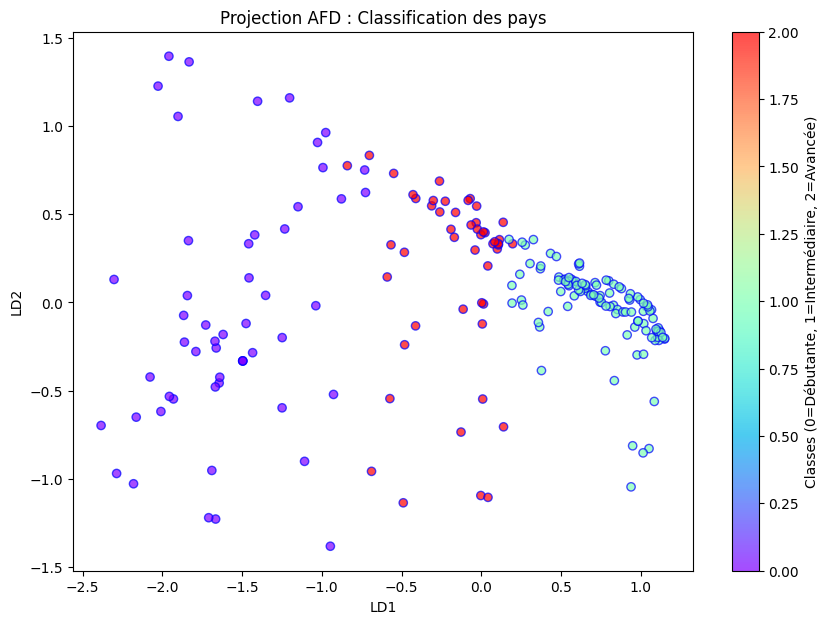

In [94]:
# Visualisation de la projection des pays selon les axes discriminants (LD1 et LD2)
plt.figure(figsize=(10, 7))
plt.xlabel('LD1')  # Premier axe discriminant
plt.ylabel('LD2')  # Deuxième axe discriminant
plt.title("Projection AFD : Classification des pays")
plt.scatter(
    X_lda[:, 0], X_lda[:, 1], 
    c=y_train, cmap='rainbow', 
    alpha=0.7, edgecolors='b'
)
plt.colorbar(label="Classes (0=Débutante, 1=Intermédiaire, 2=Avancée)")
plt.show()

# 📊 Interprétation du Graphique : Projection AFD – Classification des Pays  
## 1. Classification des pays selon leur niveau d’avancement dans la transition énergétique  

### 🔹 Interprétation du Graphique de Projection AFD  
- Le graphique montre la projection des pays selon deux axes discriminants (LD1 et LD2).  
- Les points colorés indiquent les classes de pays :  
  - **Bleu** : Pays débutants (0)  
  - **Violet** : Pays intermédiaires (1)  
  - **Rouge** : Pays avancés (2)  
- On observe une bonne séparation des classes, ce qui indique que l’AFD permet de distinguer efficacement les groupes.  

### 🔹 Séparation des Classes  
- **LD1** semble être le principal facteur de discrimination. Il sépare les pays avancés des pays intermédiaires et débutants.  
- **LD2** apporte une séparation secondaire, probablement pour distinguer les pays intermédiaires des débutants.
-  **Superposition partielle** :  
  - On observe **un certain chevauchement** entre les pays débutants et intermédiaires, indiquant que certains pays en transition intermédiaire partagent des caractéristiques avec ceux en début de transition.  
  - En revanche, **les pays avancés sont nettement séparés** du reste, montrant qu’ils forment un groupe distinct.  

## 2. Importance des Indicateurs  

### 🔹 Variance Expliquée 

In [95]:
# Affichage de la variance expliquée par chaque vecteur propre
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print(f'Eigenvector {i}: {(pair[0]/eigen_value_sums).real:.2%}') # Contribution de chaque vecteur propre

Explained Variance
Eigenvector 0: 99.61%
Eigenvector 1: 0.39%
Eigenvector 2: 0.00%
Eigenvector 3: 0.00%


- **Le premier vecteur propre (LD1) capture pratiquement toute la variance (99,61%)**.  
- Cela signifie que **LD1 seul suffit pour discriminer efficacement les pays**.  

---

### 🔹 Moyennes par Classe  

**Interprétation :**  
- Les pays avancés présentent des moyennes plus élevées pour tous les indicateurs.  
- Le **PIB par habitant** est le facteur le plus discriminant, suivi du **taux d’énergie renouvelable**.  
- L’**accès à l’électricité** et le **taux de scolarisation secondaire** jouent également un rôle dans la distinction entre les classes.  

# 📝 Réponses aux Questions  

## 1. **Peut-on classer les pays selon leur niveau d’avancement dans la transition énergétique (avancée, intermédiaire, débutante) à partir des données économiques et sociales ?**  

**Oui**, il est possible de classer les pays selon leur niveau d’avancement dans la transition énergétique en utilisant les indicateurs économiques et sociaux.  

### 🔹 Justification :  
- L'**Analyse Factorielle Discriminante (AFD)** montre une **séparation claire des classes** (débutante, intermédiaire, avancée) principalement le long de la première composante (LD1).  
- **99,61% de la variance** est expliquée par **LD1**, ce qui indique que **les variables sélectionnées** (taux d’énergie renouvelable, PIB par habitant, taux de scolarisation secondaire, accès à l’électricité) sont **efficaces pour discriminer les pays** selon leur niveau de transition énergétique.  
- **Les pays avancés sont bien séparés** des pays intermédiaires et débutants, ce qui prouve que les **indicateurs économiques et sociaux reflètent les dynamiques de transition énergétique**.  

---

## 2. **Quels indicateurs permettent de discriminer efficacement entre les pays avancés et les pays en retard dans leur transition énergétique ?**  

### 🔹 Principaux Indicateurs de Discrimination :  
1. **Taux d’énergie renouvelable**  
   - C’est **l’indicateur clé** qui distingue fortement les pays avancés des autres.  
   - Les pays avancés affichent une valeur élevée (1.55), tandis que les pays débutants sont négatifs (-0.74).  

2. **Accès à l’électricité (%)**  
   - Les pays débutants montrent des valeurs positives (0.51), ce qui reflète une **extension du réseau électrique**.  
   - Les pays avancés ont une valeur négative (-1.19), ce qui suggère qu’ils se concentrent davantage sur des améliorations **qualitatives et renouvelables**.  

3. **Taux de scolarisation secondaire (%)**  
   - Cet indicateur est **plus élevé chez les pays débutants (0.45)** que chez les pays avancés (-0.97).   
   - Cela reflète une **croissance éducative en cours** dans les pays débutants et une transition plus avancée pour les pays déjà développés.  

4. **PIB par habitant (USD)**  
   - Bien que le PIB soit **plus élevé pour les pays intermédiaires (0.80)**, il est **négatif pour les pays avancés (-0.45)**.  
   - Ce paradoxe suggère que certains **pays avancés ont des politiques énergétiques fortes malgré un PIB modéré**.  

---

## 🏆 Conclusion :  
- **L’énergie renouvelable et l’accès à l’électricité** sont les indicateurs **les plus discriminants** pour évaluer la transition énergétique.  
- **Les indicateurs sociaux (scolarisation)** jouent un rôle plus important pour différencier **les pays débutants et intermédiaires**.  
- Les données économiques et sociales permettent ainsi une **classification robuste** des pays, démontrant que les politiques de transition énergétique sont étroitement liées à ces facteurs.  
